In [1]:
# IMPORTING PACKAGES

import struct
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np
import pickle

from keras.models import Sequential
from keras.layers import Add
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import model_from_json
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2

from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder

from datetime import datetime 

import matplotlib.pyplot as plt



Using TensorFlow backend.


In [2]:
# Source: https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7
# HELPER FUNCTION FOR READING AUDIO FILE
class WavFileHelper():
    # read the files in the UrbanSound8K according to the CSV file contained in the folder
    def read_file_properties(self, filename):

        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]
        # return the channel, smaple rate and bit depth information of the sound files
        return (num_channels, sample_rate, bit_depth)

In [24]:
# EXTRACTING THE WAVE FORM FROM SOUND TRACK AND CONVERT TO 1-D ARRAY
# n is the mfcc value
def extract_feature(file_name, n):  
    standard_size = 88200  # standard size for audio signal which is about 2 s
    try:
        audio, sample_rate = librosa.core.load(file_name, mono=True, res_type='kaiser_fast') 
        fill = standard_size - audio.shape[0]
        # if the sound file is less than 2s, fill the short part with zeros
        if(fill>0):
            audio = np.concatenate((audio, np.zeros(fill)), axis=0)
        # if the file is more than 2s, clip the excess part 
        elif(fill<0):
            audio = audio[:standard_size]
            
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n)
        mfccs = librosa.util.normalize(mfccs)  
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
    # return the audio spectrum of the sound file
    return mfccs

    
    
# Set the path to the full UrbanSound dataset 
def audio_extration(n=40):
    fulldatasetpath = 'UrbanSound8K/audio/' 

    metadata = pd.read_csv(fulldatasetpath + 'metadata/UrbanSound8K.csv')

    features = []
    label_amount = {}

    # Iterate through each sound file and extract the features 
    for index, row in metadata.iterrows():
    
        file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
        class_label = row["class"]
        data = extract_feature(file_name, n)
        label_amount[class_label] = label_amount.get(class_label, 0) + 1
        features.append([data, class_label])


    # Convert into a Panda dataframe 
    featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

    #print('Finished feature extraction from ', len(featuresdf), ' files')
    return featuresdf, metadata

In [25]:
# EXTRACT THE CHANNELS, SAMPLE RATE AND BIT DEPTH DATA FROM SOUNDS FILE
# use the previous functinons and actually do the info extraction
def info_extration(metadata):
    wavfilehelper = WavFileHelper()

    audiodata = []
    for index, row in metadata.iterrows():
    
        file_name = os.path.join(os.path.abspath('UrbanSound8K/audio/'),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
        data = wavfilehelper.read_file_properties(file_name)
        audiodata.append(data)

    # Convert into a Panda dataframe
    audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])
    return audiodf

In [ ]:
# This part is used to test the previous functions
'''
print(type(featuresdf.iloc[0]['feature']))
print(featuresdf.head())
print()
print(audiodf.head())

lst = [0,1,10,23,96,106,114,122,171,196]
for n in lst:
    import matplotlib.pyplot as plt
    %matplotlib inline  
    plt.plot(featuresdf.iloc[n]['feature'][5:])
    plt.ylabel('Amplitude')
    plt.show()
    print(featuresdf.iloc[n]['class_label'])
'''

In [26]:
# SEPERATING DATA TO TRAINING AND TESTING WITH 80% 20% RATIO
# use the previous functions and actually read and store all the files in the dataset
def data_seperation(featuresdf):
    # Convert features and corresponding classification labels into numpy arrays
    X = np.array(featuresdf.feature.tolist())
    y = np.array(featuresdf.class_label.tolist())

    # Encode the labels using Onehot technique
    lable_encoder = LabelEncoder()
    y_one_hot = to_categorical(lable_encoder.fit_transform(y)) 

    # split the dataset 
    train_features, validate_features, train_labels, validate_labels = train_test_split(X, y_one_hot, test_size=0.11, random_state = 42)
    train_features, test_features, train_labels, test_labels = train_test_split(train_features, train_labels, test_size=0.12, random_state = 42)
    #print("Training data set size: ",train_features.shape[0])
    #print("Validate data set size: ",validate_features.shape[0])
    #print("Test data set size: ",test_features.shape[0])
    return (train_features, validate_features, test_features, train_labels, validate_labels, test_labels, y_one_hot)

In [27]:
# Save the data for easy access
def save_data(n, train_features, validate_features, test_features, train_labels, validate_labels, test_labels, y_one_hot):
    pickle_file = 'audio_features_mfcc'+ str(n) +'.pickle'
    if not os.path.isfile(pickle_file):
        print('Saving data to pickle file...')
        try:
            with open(pickle_file, 'wb') as pfile:
                pickle.dump(
                    {
                        'train_dataset': train_features,
                        'train_labels': train_labels,
                        'valid_dataset': validate_features,
                        'valid_labels': validate_labels,
                        'test_dataset': test_features,
                        'test_labels': test_labels,
                        'y_one_hot': y_one_hot,
                    },
                    pfile, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', pickle_file, ':', e)
            raise

    print('Data cached in pickle file.')

In [7]:
# MODEL BUILDING
# n is mfcc number
def model_building(n, validate_features, validate_labels, y_one_hot):
    num_rows = n  # audio frequency spectrum 173*n
    num_columns = 173   
    num_channels = 1   # combine 2 channels to one channel
    
    #validate_features = validate_features.reshape(validate_features.shape[0], num_rows, num_columns, num_channels) 
    num_labels = y_one_hot.shape[1]
    
    filter_size = 2   
    drop_rate = 0.4  # dropping 40% of data to prevent over-fitting

    # Construct model 
    model = Sequential()
    # Layer 1 - Conv Layer 1
    model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(drop_rate))

    # Layer  - Conv Layer 2
    model.add(Conv2D(filters=32, kernel_size=2))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(drop_rate))

    # Layer 3 - Conv Layer 3
    model.add(Conv2D(filters=64, kernel_size=2))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(drop_rate))

    # Layer 4 - Conv Layer 4
    model.add(Conv2D(filters=128, kernel_size=2))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(drop_rate))
    
    # Layer 5 - Flatten Layer
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_labels, activation='softmax'))
    
    
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    # Pre-training evaluation
    
    # Display model architecture summary 
    # model.summary()

    # Calculate pre-training accuracy 
    # score = model.evaluate(validate_features, validate_labels, verbose=1)
    # accuracy = 100*score[1]

    # print("Pre-training accuracy: %.4f%%" % accuracy)
    return model

In [8]:
# Train the model
def model_training(n, model, train_features, train_labels, validate_features, 
                   validate_labels, num_epochs=150, num_batch_size=256):

    checkpointer = ModelCheckpoint(filepath='weights.best.basic_cnn.hdf5', verbose=1, save_best_only=True)
    
    num_rows = n  # audio frequency spectrum 173*40
    num_columns = 173   
    num_channels = 1   # combine 2 channels to one channel
    train_features = train_features.reshape(train_features.shape[0], num_rows, num_columns, num_channels) 
    validate_features = validate_features.reshape(validate_features.shape[0], num_rows, num_columns, num_channels)   
    
    #start = datetime.now()

    history = model.fit(train_features, train_labels, batch_size=num_batch_size, epochs=num_epochs, validation_data=(validate_features, validate_labels), shuffle=True, callbacks=[checkpointer], verbose=1)

    #duration = datetime.now() - start
    #print("Training completed in time: ", duration)
    return history
       

In [ ]:
# MobileNet model
def mobileNet_building(n, validate_features, validate_labels, y_one_hot):
    num_rows = n  # audio frequency spectrum n*173
    num_columns = 173   
    num_channels = 3 
    
    drop_rate = 0.4  # dropping 40% of data to prevent over-fitting
              
    input_img = Input(shape=(num_rows, num_columns, num_channels))
    mn = MobileNetV2(input_shape=(num_rows, num_columns, num_channels), include_top=False, weights='imagenet',input_tensor=input_img, pooling='max')

    # add a layer at the end of the model
    # the original MobileNet has 1000 classes, here only have 10 classes
    # so add a layer with 10 output at the end
    model = Sequential()
    model.add(mn)
    model.add(Dense(10, activation='softmax'))
    
    # Compile the MobileNet model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    model.summary()
    return model  

In [ ]:
# Train the model
def mobileNet_training(n, model, train_features, train_labels, validate_features, 
                   validate_labels, num_epochs=150, num_batch_size=256):
    
    #start = datetime.now()

    history = model.fit(train_features, train_labels, batch_size=num_batch_size, epochs=num_epochs, validation_data=(validate_features, validate_labels), shuffle=True, verbose=1)

    #duration = datetime.now() - start
    #print("Training completed in time: ", duration)
    return history

In [9]:
# load the pickle file to 
def load_data(pickle_file_path):
    file_dict = pickle.load( open( pickle_file_path, "rb" ))
    return file_dict['train_dataset'], file_dict['valid_dataset'],\
file_dict['test_dataset'],file_dict['train_labels'],\
file_dict['valid_labels'], file_dict['test_labels'], file_dict['y_one_hot']

In [17]:
# Pipe Line
# experimenting mfcc number
def pip(n):
    # data preprocessing
    '''
    featuresdf, metadata = audio_extration(n)
    audiodf = info_extration(metadata)
    train_features, validate_features, test_features, \
    train_labels, validate_labels, test_labels, y_one_hot = data_seperation(featuresdf)
    save_data(n, train_features, validate_features, test_features, train_labels, validate_labels, test_labels, y_one_hot)
    '''
    # load pre-processed data
    pickle_file_path = 'audio_features_mfcc40.pickle'
    train_features, validate_features, test_features, train_labels,\
    validate_labels, test_labels, y_one_hot = load_data(pickle_file_path)
    
    # Simple model
    model = model_building(n, validate_features, validate_labels, y_one_hot)
    history = model_training(n, model, train_features, train_labels, validate_features, 
                             validate_labels, num_epochs=150, num_batch_size=256)
    # Evaluating the model on the training and testing set

    score = model.evaluate(train_features, train_labels, verbose=0)
    print("Training Accuracy: ", score[1])

    score = model.evaluate(valid_features, test_labels, verbose=0)
    print("Validation Accuracy: ", score[1])
    
    
    # MobileNet
    #train_features = np.stack((train_features, train_features, train_features), axis=3)
    
    #validate_features = np.stack((validate_features, validate_features, validate_features), axis=3)
    #print(train_features.shape)
    #print(validate_features.shape)
    #model = mobileNet_building(n, validate_features, validate_labels, y_one_hot)
    #history = mobileNet_training(n, model, train_features, train_labels, validate_features, 
    #                         validate_labels, num_epochs=50, num_batch_size=256)
    
    return history, model

In [53]:
# evaluate the effect of different MFCC number vs model accuracy
mfcc_num = list(range(40,260,20))
accuracy = []
history_list = []
for n in mfcc_num:
    history = pip(n)
    history_list.append(history)
    accuracy.append(history.history['val_acc'][-1])

plt.plot(mfcc_num, accuracy)
plt.title('Model Accuracy vs. MFCC Number')
plt.ylabel('Accuracy')
plt.xlabel('MFCC Number')
plt.savefig('Model Accuracy vs. MFCC Number.png')
plt.show()


Train on 6838 samples, validate on 961 samples
Epoch 1/150
6838/6838 [==============================] - 12s 2ms/step - loss: 2.1950 - acc: 0.1676 - val_loss: 2.1446 - val_acc: 0.2279

Epoch 00001: val_loss improved from inf to 2.14464, saving model to weights.best.basic_cnn.hdf5
Epoch 2/150
6838/6838 [==============================] - 11s 2ms/step - loss: 1.9798 - acc: 0.2723 - val_loss: 1.9321 - val_acc: 0.3049

Epoch 00002: val_loss improved from 2.14464 to 1.93206, saving model to weights.best.basic_cnn.hdf5
Epoch 3/150
6838/6838 [==============================] - 11s 2ms/step - loss: 1.8367 - acc: 0.3184 - val_loss: 1.8256 - val_acc: 0.3538

Epoch 00003: val_loss improved from 1.93206 to 1.82564, saving model to weights.best.basic_cnn.hdf5
Epoch 4/150
6838/6838 [==============================] - 12s 2ms/step - loss: 1.7272 - acc: 0.3655 - val_loss: 1.7138 - val_acc: 0.4100

Epoch 00004: val_loss improved from 1.82564 to 1.71378, saving model to weights.best.basic_cnn.hdf5
Epoch 5/1

KeyboardInterrupt: 

In [59]:
pickle_file = 'training_history.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                        'history_list': history_list,

                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Training history saved to pickle file.')

Training history saved to pickle file.


In [60]:
# training the model based on pretrained weights
history, model = pip(40)

Train on 6838 samples, validate on 961 samples
Epoch 1/150
6838/6838 [==============================] - 13s 2ms/step - loss: 2.2076 - acc: 0.1481 - val_loss: 2.1779 - val_acc: 0.2435

Epoch 00001: val_loss improved from inf to 2.17792, saving model to weights.best.basic_cnn.hdf5
Epoch 2/150
6838/6838 [==============================] - 12s 2ms/step - loss: 2.0178 - acc: 0.2675 - val_loss: 1.9808 - val_acc: 0.3278

Epoch 00002: val_loss improved from 2.17792 to 1.98083, saving model to weights.best.basic_cnn.hdf5
Epoch 3/150
6838/6838 [==============================] - 14s 2ms/step - loss: 1.8135 - acc: 0.3472 - val_loss: 1.7730 - val_acc: 0.3954

Epoch 00003: val_loss improved from 1.98083 to 1.77296, saving model to weights.best.basic_cnn.hdf5
Epoch 4/150
6838/6838 [==============================] - 12s 2ms/step - loss: 1.6801 - acc: 0.4000 - val_loss: 1.6595 - val_acc: 0.4225

Epoch 00004: val_loss improved from 1.77296 to 1.65948, saving model to weights.best.basic_cnn.hdf5
Epoch 5/1

KeyboardInterrupt: 

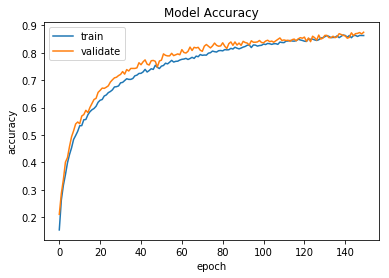

In [19]:
# summarize history for accuracy
#print(history.history.keys()) 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [46]:
pickle_file_path = 'audio_features_mfcc40.pickle'
train_features, validate_features, test_features, train_labels,\
validate_labels, test_labels, y_one_hot = load_data(pickle_file_path)
train_features = train_features.reshape( (train_features.shape[0], train_features.shape[1],  train_features.shape[2], 1))
validate_features = validate_features.reshape((validate_features.shape[0], validate_features.shape[1],  validate_features.shape[2], 1))
test_features = test_features.reshape((test_features.shape[0], test_features.shape[1],  test_features.shape[2], 1))
print(test_features.shape)

(933, 40, 173, 1)


In [47]:
# Evaluating the model on the training and testing set

score = model.evaluate(train_features, train_labels, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(validate_features, validate_labels, verbose=1)
print("Validation Accuracy: ", score[1])

score = model.evaluate(test_features, test_labels, verbose=1)
print("Test Accuracy: ", score[1])


6838/6838 [==============================] - 2s 288us/step
Training Accuracy:  0.9226381982512974
961/961 [==============================] - 0s 286us/step
Validation Accuracy:  0.8751300728407908
933/933 [==============================] - 0s 289us/step
Test Accuracy:  0.8713826366559485


In [48]:
# Source: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# Save model to JSON
model_json = model.to_json()
with open("sound_classification_model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [49]:
# Load the saved model
# load json and create model
json_file = open('sound_classification_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")


Loaded model from disk


In [51]:
# Loadoaded model
loaded_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [52]:
# Test performance of user input audio file
# x need to be numpy array of shape (40, 173) processed through mfcc
# make sure the sound file length is <= 2s, or doesn't contians info after 2s
file_path = ''
x = extract_feature(file_path)
print(x.shape)
predictions = loaded_model.predict(x)
print(predictions)

TypeError: extract_feature() missing 1 required positional argument: 'n'

In [ ]:
# next step:
# 1. Run the model
# 2. Save the data set (train/validation/test data)
# 3. Save the model
# 4. Improve model performance
# 5. Modify the model - possible: MobileNet, VGG16, LeNet, GoogLeNet
# 6. Predict the user input audio clip